# Steering Patchy Particles using Multivalent Electrolytes

_Alexei Abrikossov and Mikael Lund, April 2017_

In this Notebook we setup Metropolis Monte Carlo (MC) simulations to calculate the interaction free energy between a pair of charged, patchy particles (CPPs) in 1:1, 1:3, and 3:1 electrolyte solution, as well as analyse their electrostatic energy in terms of a multipole decomposition. The notebook will generate all input for the simulations, submit the jobs to a slurm cluster (or run them locally), and finally plot potentials of mean force (PMF) as well as multipolar energies as a function of CPP-CPP mass center separation.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy import integrate
import pandas as pd
import os.path, os, sys, json, shutil, glob
from pathlib import Path
import pickle
from sys import stdout
from math import exp, sqrt

mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rcParams.update({'font.size': 16, 'figure.figsize': [6.0, 5.0]})

try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

### Download and compile the MC software Faunus

__NOTE: This step can be skipped if you just want to plot existing data.__

This downloads the MC package _Faunus_ from http://github.com/mlund/faunus, and compile a custom MC program, `twobody.cpp` found in the `mc/` folder. This will simulate CPPs and ions in a cylindrical container using a Coulomb + Weeks-Chandler-Andersen potential. Solvent is treated as a background dielectric and the model strongly resembles the primitive model of electrolytes, albeit with soft repulsion.

**Note** that the GCC version specified below is merely for internal use and should be removed or adjusted to your specific setup. A compiler with full C++11 support is required, i.e. GCC (>=4.9), Clang, Intel.

In [2]:
%%bash -s "$workdir"

# these 4 lines are specific to your system and should be edited/deleted
#module add GCC/6.2.0-2.27
#module add CMake
#export CXX=/sw/easybuild/software/Core/GCCcore/6.2.0/bin/g++
#export CC=/sw/easybuild/software/Core/GCCcore/6.2.0/bin/gcc

cd $1
if [ ! -d "faunus" ]; then
  git clone https://github.com/mlund/faunus.git
  cd faunus
  git checkout tags/v1.0.0
else
  cd faunus
fi

CXX=clang++ CC=clang cmake . -DCMAKE_BUILD_TYPE=Release -DMYPLAYGROUND=$1/mc 
make twobody twobody-cuboid -j4
cd $1

-- Configuring done
-- Generating done
-- Build files have been written to: /Users/mikael/github/cppm/faunus
[ 33%] Built target xdrfile
[ 83%] Built target libfaunus
[100%] Built target twobody
[ 33%] Built target xdrfile
[ 83%] Built target libfaunus
[100%] Built target twobody-cuboid


......................................................................
  Faunus is running in Release mode recommended for production runs.
  For setting up simulations it is HIGHLY recommended to use Debug
  mode to enable run-time checks and assertions:

  -DCMAKE_BUILD_TYPE=RelWithDebInfo
**********************************************************************



### Function for generating JSON input file for Faunus

The `moleculelist` keywords define the two CPPs (and later salt) and the insertion direction (`insdir`) and insertion offset (`insoffset`) combination ensures that they are inserted on the length axis ($z$) of the cylinder. Likewise, the translational/rotational move (`moltransrot2body`) ensures that only $z$ movement is performed.
More detail about input parameters can be found in the code documentation for Faunus (http://github.com/mlund/faunus).

In [3]:
import os.path, os, sys, json, shutil
from pathlib import Path

def mkinput(ions):
    js = {
          "energy" : {
            "nonbonded" : {
              "coulomb" : { "epsr" : 78.7 }
            },
            "cmconstrain" : {
              "0sphere 1sphere" : { "mindist": 0, "maxdist": 99 }
              }
            },
          "atomlist" : {
            "UP":  dict(q=0,  sigma=4.0, eps=ljeps, mw=1e-3),
            "NP":  dict(q=-1, sigma=4.0, eps=ljeps, mw=1e-3),
            "PP":  dict(q=1,  sigma=4.0, eps=ljeps, mw=1e-3),
            "MP":  dict(q=0,  sigma=40,  eps=ljeps, mw=1e6),
            "Na":  dict(q=1,  sigma=4.0, eps=ljeps, mw=1e-3, dp=50),
            "La":  dict(q=3,  sigma=1.0, eps=ljeps, mw=1e-3, dp=10),
            "PO4": dict(q=-3, sigma=1.0, eps=ljeps, mw=1e-3, dp=10),
            "Cl":  dict(q=-1, sigma=4.0, eps=ljeps, mw=1e-3, dp=50)
              },
          "moleculelist": {
              "0sphere":  { "structure":xyzfile, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 "+str(offset)},
              "1sphere":  { "structure":xyzfile, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 -"+str(offset)}
              },
          "moves" : {
              "moltransrot2body" : {
                "0sphere" : { "dp":dp, "dprot":0.5 }, 
                "1sphere" : { "dp":dp, "dprot":0.5 } 
                }
          },
          "analysis" : {
            "pqrfile" :   { "file": "confout.pqr"  },
            "statefile" : { "file": "state" },
            "xtcfile" :   { "file": "traj.xtc", "nstep": nstep_xtc },
            "molrdf" : { "nstep":5, "pairs" :
                        [
                              dict(file="rdf.dat", dim=1, name1="0sphere", name2="1sphere", dr=0.1)
                        ]
                       },   
            "chargemultipole" : {"nstep":1000, "mollist":["0sphere", "1sphere"]},
            "multipoledistribution" :
                { "file": "multipole.dat", "nstep":10, "groups":["0sphere", "1sphere"] }
          },
          "system" : {
              "temperature" : 298.15,
              "geometry" : { "length" : cyllen, "radius" : cylradius },
              "mcloop"   : { "macro" : 10, "micro" : micro }
              }
          }
    
    for name, N in ions.items(): # add molecules for ions and add translational move
        if N>0:
            js['moleculelist'][name] = dict(Ninit=N, atomic=True, atoms=name)
            if not 'atomtranslate' in js['moves']:
                js['moves']['atomtranslate'] = {}
            js['moves']['atomtranslate'][name] = dict(peratom=True)

    with open('twobody.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))
        
def volume():
    return np.pi*cylradius**2 * cyllen

cylradius=55 # cylinder radius (angstrom) [55,79]
cyllen=200   # cylinder length (angstrom)
ljeps=2.479  # WCA epsilon (kJ/mol)
dp=5         # COM translational displacement parameter (angstrom)
nstep_xtc=0  # frequency for saving frames to xtc trajectory file

### Set up Parameter Space

Here we define the CPPMs to simulate and which salt concentrations and valencies. The resulting Pandas object further contains information about labels used for plotting later on.

In [4]:
def M2N(molarity):
    ''' Convert mol/l to nearest integer number of particles in cylinder '''
    return int( round( molarity * volume() * 1e-27 * 6.022e23 ) )

param = pd.DataFrame({
    # P00 1:1 salt
    'P00-1:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            label=r'$P_0^0$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P00-1:1-100mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            label=r'$P_0^0$ 100 mM 1:1', color='blue',
            cs=0.1, ions = dict(Na=16+M2N(0.1), Cl=M2N(0.1)), ljeps=[2.479]
        ),
    # P00 3:1 salt
    'P00-3:1-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            label=r'$P_0^0$ 5 mM 3:1', color='blue',
            cs=0.005, ions = dict(Na=16, La=M2N(0.005), Cl=3*M2N(0.005)), ljeps=[2.479]
        ),
    # P00 1:3 salt
    'P00-1:3-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            label=r'$P_0^0$ 5 mM 1:3', color='blue',
            cs=0.005, ions = dict(PO4=M2N(0.005), Na=16+3*M2N(0.005)), ljeps=[2.479]
        ),
    # P18 1:1 salt
    'P18-1:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            label=r'$P_8^1$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P18-1:1-10mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-point.aam',
            label=r'$\tilde{P}_8^1$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P18-1:1-100mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            label=r'$P_8^1$ 100 mM 1:1', color='blue',
            cs=0.1, ions = dict(Na=16+M2N(0.1), Cl=M2N(0.1)), ljeps=[2.479]
        ),
    'P18-1:1-100mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-point.aam',
            label=r'$\tilde{P}_8^1$ 100 mM 1:1', color='blue',
            cs=0.10, ions = dict(Na=16+M2N(0.10), Cl=M2N(0.10)), ljeps=[2.479]
        ),
    # P18 3:1 salt
    'P18-3:1-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            label=r'$P_8^1$ 5 mM 3:1', color='blue',
            cs=0.005, ions = dict(Na=16, La=M2N(0.005), Cl=3*M2N(0.005)), ljeps=[2.479]
        ),
    # P18 1:3 salt (i.e. Na3PO4)
    'P18-1:3-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            label=r'$P_8^1$ 5 mM 1:3', color='blue',
            cs=0.005, ions = dict(PO4=M2N(0.005), Na=16+3*M2N(0.005)), ljeps=[2.479]
        )
    })

param.T

,charge,color,cs,ions,label,ljeps,xyzfile
P00-1:1-100mM,-8,blue,0.1,"{'Cl': 114, 'Na': 130}",$P_0^0$ 100 mM 1:1,[2.479],/Users/mikael/github/cppm/mc/sphere-P00-reduce...
P00-1:1-10mM,-8,blue,0.01,"{'Cl': 11, 'Na': 27}",$P_0^0$ 10 mM 1:1,[2.479],/Users/mikael/github/cppm/mc/sphere-P00-reduce...
P00-1:3-5mM,-8,blue,0.005,"{'PO4': 6, 'Na': 34}",$P_0^0$ 5 mM 1:3,[2.479],/Users/mikael/github/cppm/mc/sphere-P00-reduce...
P00-3:1-5mM,-8,blue,0.005,"{'Cl': 18, 'La': 6, 'Na': 16}",$P_0^0$ 5 mM 3:1,[2.479],/Users/mikael/github/cppm/mc/sphere-P00-reduce...
P18-1:1-100mM,-8,blue,0.1,"{'Cl': 114, 'Na': 130}",$P_8^1$ 100 mM 1:1,[2.479],/Users/mikael/github/cppm/mc/sphere-P18-reduce...
P18-1:1-100mM-point,-8,blue,0.1,"{'Cl': 114, 'Na': 130}",$\tilde{P}_8^1$ 100 mM 1:1,[2.479],/Users/mikael/github/cppm/mc/sphere-P18-point.aam
P18-1:1-10mM,-8,blue,0.01,"{'Cl': 11, 'Na': 27}",$P_8^1$ 10 mM 1:1,[2.479],/Users/mikael/github/cppm/mc/sphere-P18-reduce...
P18-1:1-10mM-point,-8,blue,0.01,"{'Cl': 11, 'Na': 27}",$\tilde{P}_8^1$ 10 mM 1:1,[2.479],/Users/mikael/github/cppm/mc/sphere-P18-point.aam
P18-1:3-5mM,-8,blue,0.005,"{'PO4': 6, 'Na': 34}",$P_8^1$ 5 mM 1:3,[2.479],/Users/mikael/github/cppm/mc/sphere-P18-reduce...
P18-3:1-5mM,-8,blue,0.005,"{'Cl': 18, 'La': 6, 'Na': 16}",$P_8^1$ 5 mM 3:1,[2.479],/Users/mikael/github/cppm/mc/sphere-P18-reduce...


## Potential of mean force from histogram method

We first calculate the potential of mean force between two neutral spheres by simply sampling the COM-COM distance probability distribution, followed by Boltzmann inversion.
The COM's of the two macromolecules are able to translate along a line which coinsides with the axis of a cylindrical simulation cell with hard boundaries. During simulation, the molecules further rotate around their mass centers. Since the molecules in this way are constrained on a line, there is no need to correct for the increasing volume element normally needed for simulations in free space. In the Faunus input file, this is controlled by the `dim=1` keyword in the `molrdf` section.

In [5]:
%%writefile $workdir/mc/submit.sh
#!/bin/bash

# This is a submit file, should you be using a cluster. Ignore this if running locally.

#SBATCH -A snic2017-1-48
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -t 40:00:00
../twobody > out

Overwriting /Users/mikael/github/cppm/mc/submit.sh


In [7]:
%cd -q $workdir/mc
for directory, d in param.items():
    for eps in d.ljeps: # loop over LJ epsilon values (we just have one)
        ljeps = eps
        ionstr = ''
        for ion, N in d.ions.items(): # salt particles
            ionstr = ion+str(N) + ionstr
        if not os.path.isdir(directory):
            %mkdir $directory
        if os.path.isdir(directory):
            %cd $directory
            if not os.path.isfile('out'):
                xyzfile=d.xyzfile
                nstep_xtc=0                   # interval to save xtc file (0=never)
                offset=50/2.0                 # COM offset from origo (center of container)
                micro=1000                    # number of micro steps (equilibration)
                mkinput( d.ions )             # make json input file for faunus

                !rm -fR state                 # make sure there's no old state (restart) file
                !nice ../twobody &> eq        # eq. run

                micro=5000000                # number of micro steps for production
                mkinput( d.ions )

                if shutil.which('sbatch') is not None: # run on slurm cluster...
                    !sbatch ../submit.sh
                else:                                  # ...or locally (slow) ?
                    !../twobody > out

            %cd -q ..
print('done.')

/Users/mikael/github/cppm/mc/P00-1:1-100mM
/Users/mikael/github/cppm/mc/P00-1:1-10mM
/Users/mikael/github/cppm/mc/P00-1:3-5mM
/Users/mikael/github/cppm/mc/P00-3:1-5mM
/Users/mikael/github/cppm/mc/P18-1:1-100mM
/Users/mikael/github/cppm/mc/P18-1:1-100mM-point
/Users/mikael/github/cppm/mc/P18-1:1-10mM
/Users/mikael/github/cppm/mc/P18-1:1-10mM-point
/Users/mikael/github/cppm/mc/P18-1:3-5mM
/Users/mikael/github/cppm/mc/P18-3:1-5mM
done.


### Multipole Decomposition

As a function of mass center separation, we plot mulitipolar electrostatic energies between pairs of CPPs.
The analysis is done on the fly during MC simulation and controlled by the `multipoledistribution` section in the JSON input file. More information about this analysis can be found in the code documentation for Faunus, see http://github.com/mlund/faunus.


In [8]:
%cd -q $workdir/mc

from matplotlib.ticker import AutoMinorLocator
def plotmultipole(data, ax, xlim):
    for directory, d in data.items():
        ionstr = ''
        for ion, N in d.ions.items(): # loop over all ion conditions
            ionstr = ion+str(N) + ionstr

        if os.path.isdir(directory):
            %cd -q $directory
            if os.path.isfile('multipole.dat'):
                r,exact,total,ionion,iondip,dipdip,ionquad, mucorr= np.loadtxt('multipole.dat', unpack=True, skiprows=2)
                ax.plot(r, exact, 'ko', alpha=0.6, ms=4, label='exact', markevery=4)
                ax.plot(r, total, 'k-', lw=2, label='multipole sum')
                ax.plot(r, ionion, lw=2, label='ion-ion')
                ax.plot(r, iondip, lw=2, label='ion-dipole')
                ax.plot(r, dipdip, lw=2, label='dipole-dipole')
                ax.plot(r, ionquad, lw=2, label='ion-quadrupole')
                #ax.plot(r, mucorr*10, '--', lw=2, ms=4, alpha=0.6, label=r'$10\cdot\langle \mu_1\mu_2\rangle$')
                
                ax.set_title(d.label, verticalalignment='bottom')

            %cd -q ..

    ax.set_xlabel(r'$R$ (Å)')
    ax.set_ylabel(r'Electrostatic energy ($k_BT$)')
    ax.set_xlim(xlim)
    ax.set_ylim(-5.3,14)

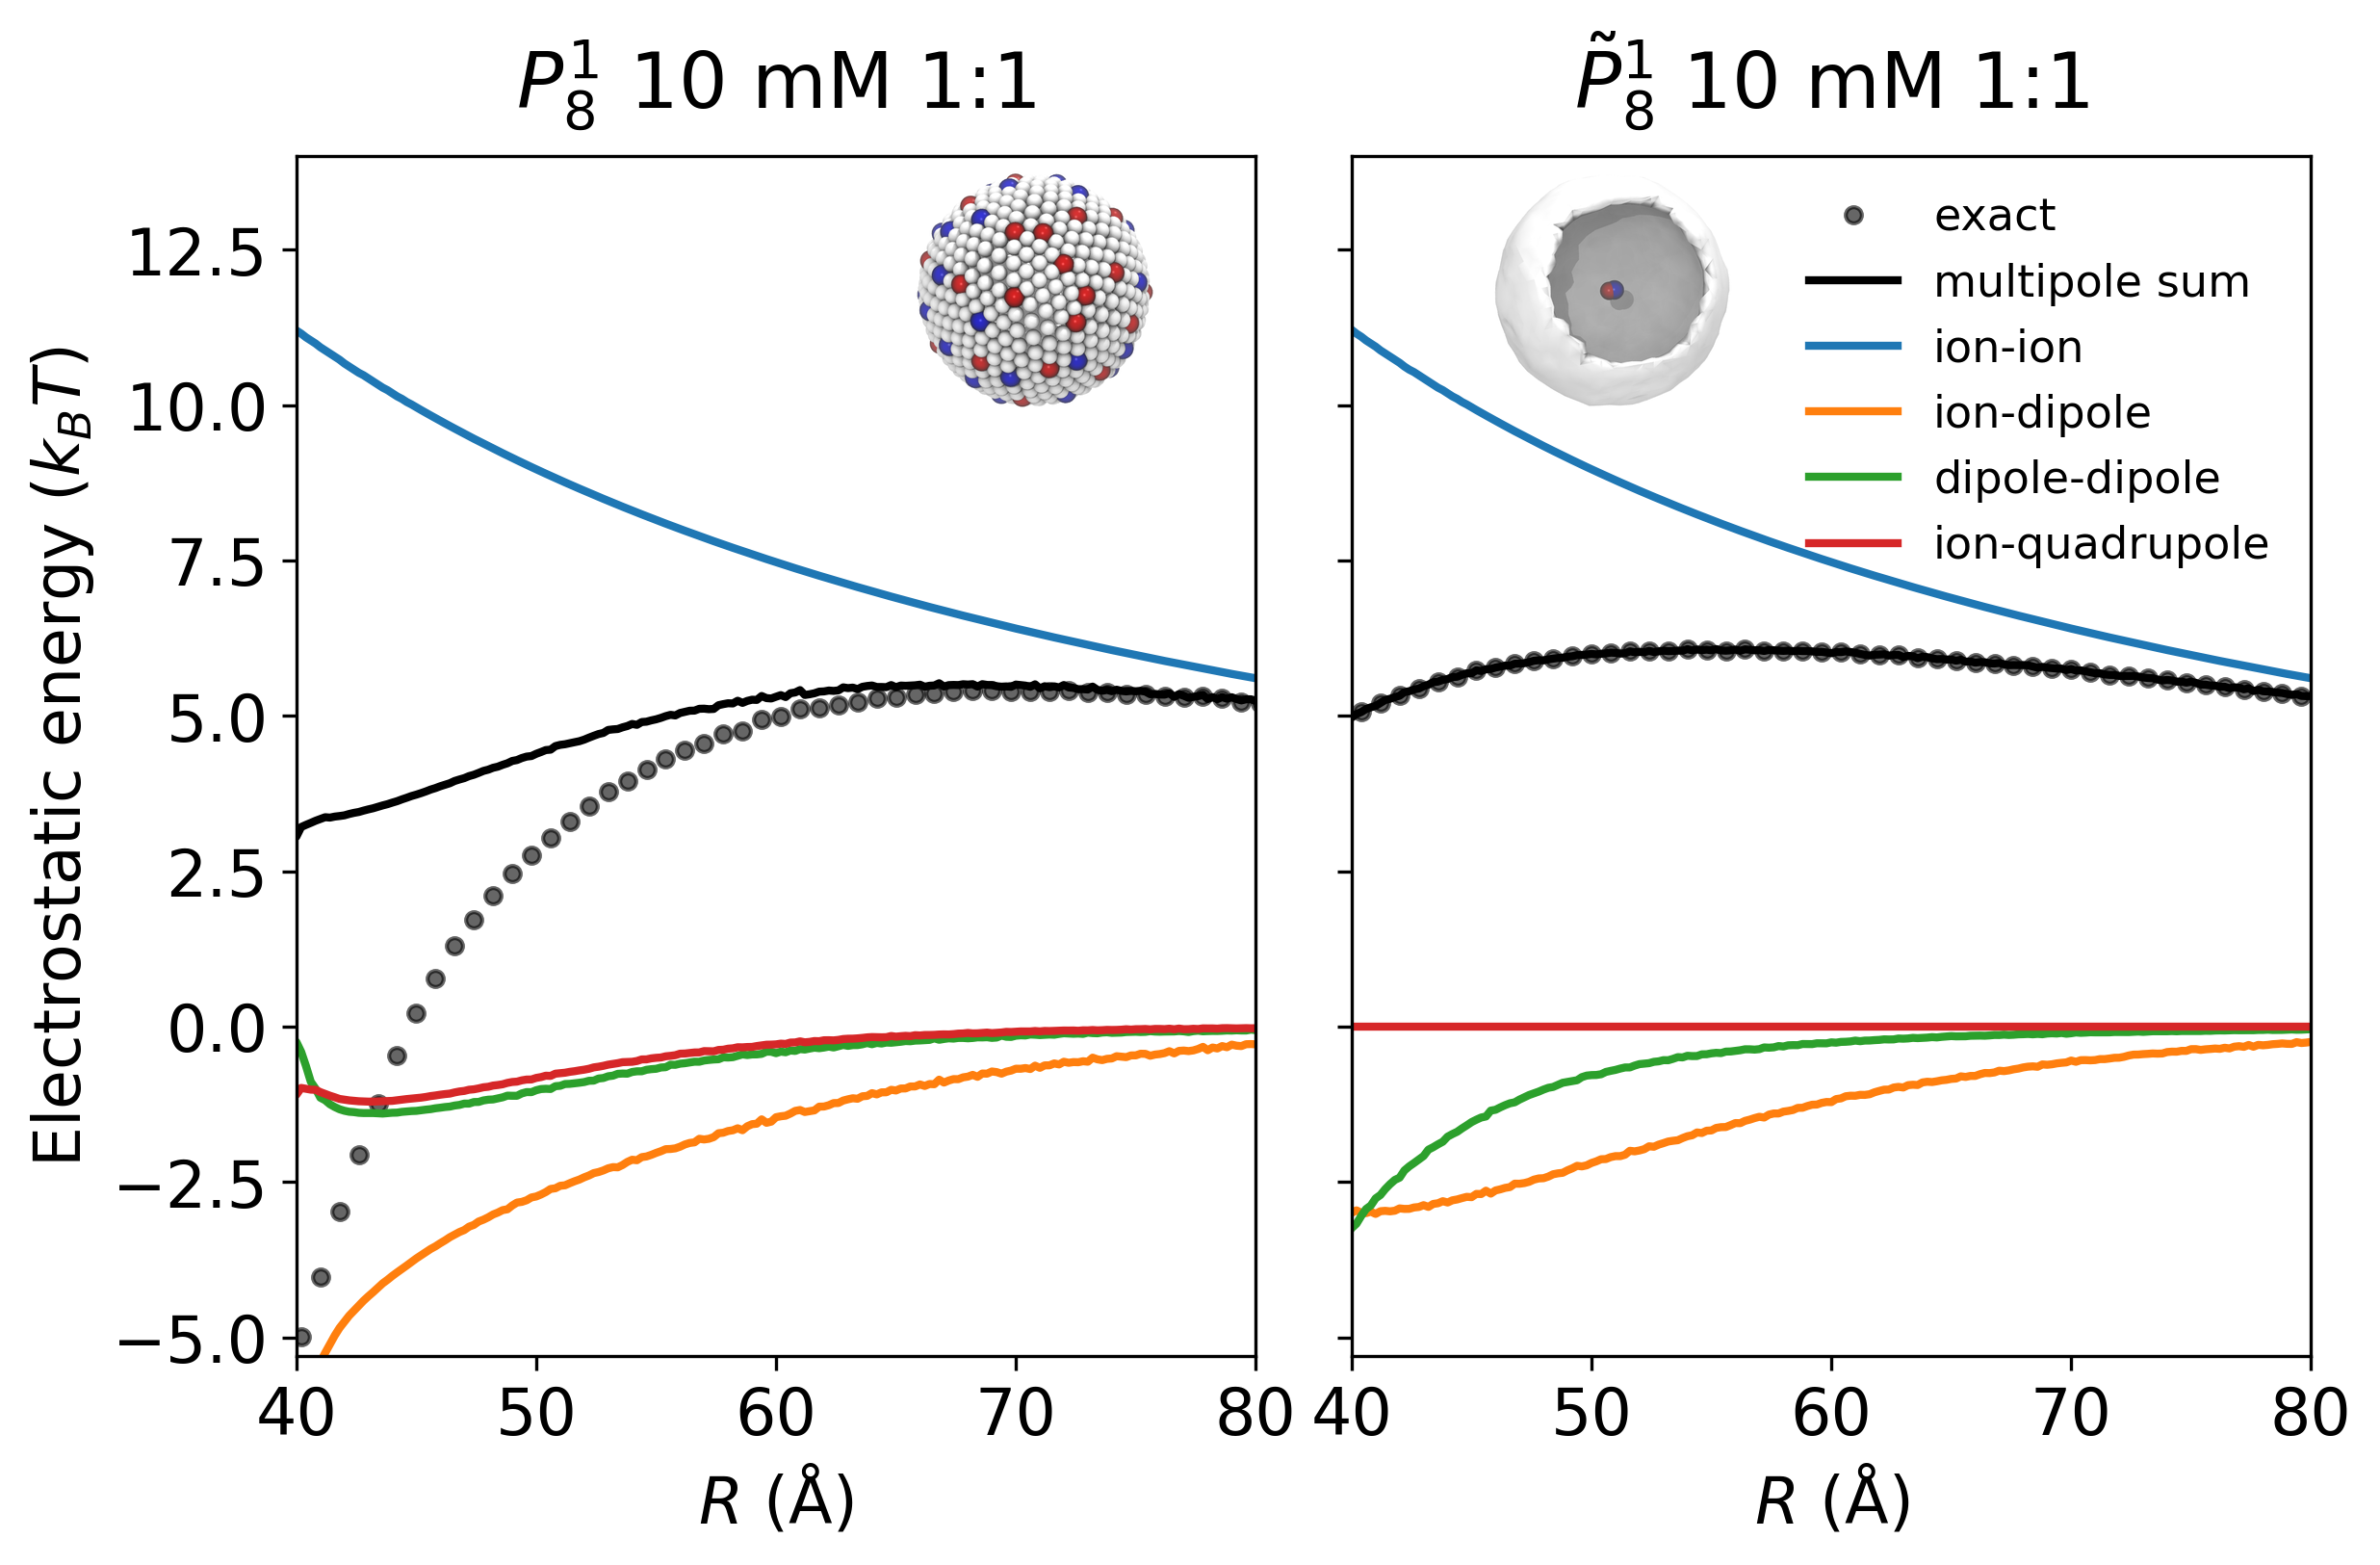

In [9]:
from matplotlib.cbook import get_sample_data

try:
    from PIL import Image
except ImportError:
    import Image

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5.5)
f.set_figwidth(9)
f.dpi=300
plotmultipole(param[['P18-1:1-10mM']], ax=ax1, xlim=[40,80] )
plotmultipole(param[['P18-1:1-10mM-point']], ax=ax2, xlim=[40,80] )
ax2.legend(loc=0, frameon=False, fontsize='x-small', ncol=1)
ax2.set_ylabel('')
f.subplots_adjust(wspace=0.1)

# image insets
imgsize=250,250
im1 = Image.open('P18.png')
im1.thumbnail(imgsize, Image.ANTIALIAS)
im2 = Image.open('P18-point.png')
im2.thumbnail(imgsize, Image.ANTIALIAS)
ypos=1200
f.figimage(X=np.array(im1).astype(np.float)/255, xo=950, yo=ypos, resize=False, zorder=10)
f.figimage(X=np.array(im2).astype(np.float)/255, xo=1550, yo=ypos, resize=False, zorder=10)

plt.savefig('multipol-monovalent.png', bbox_inches='tight', dpi=300)

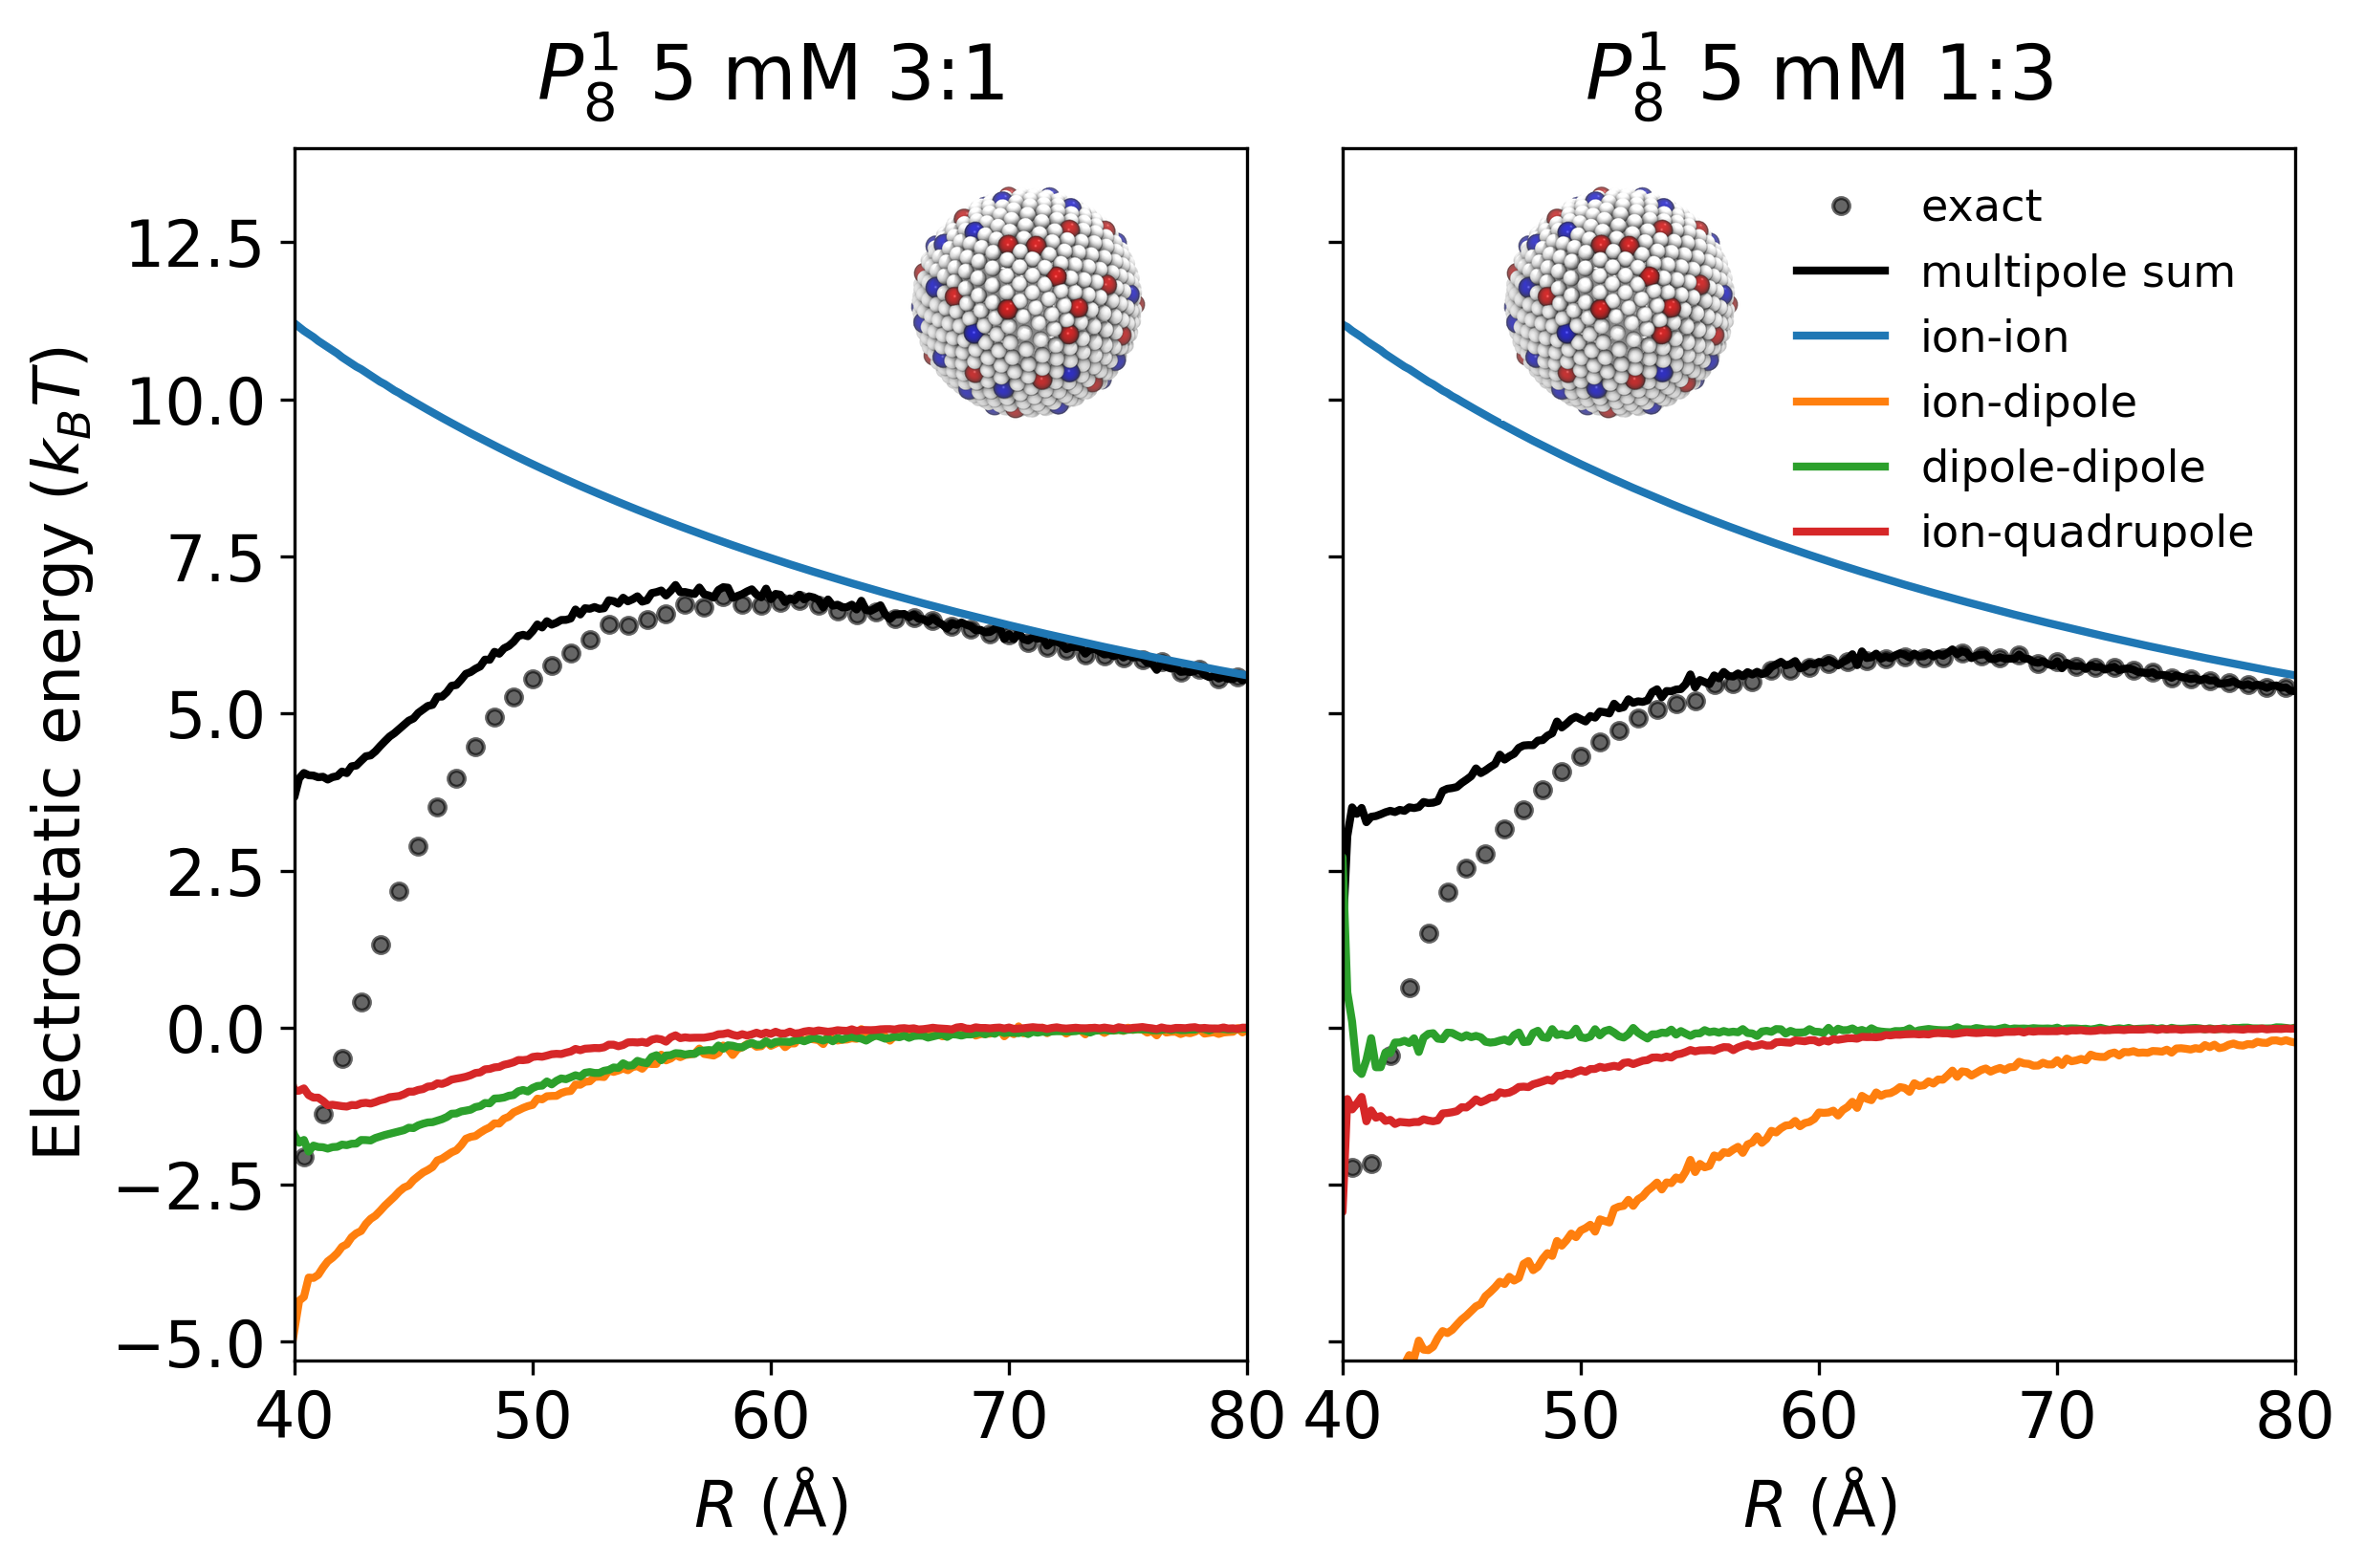

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5.6)
f.set_figwidth(9)
f.dpi=300
plotmultipole(param[['P18-3:1-5mM']], ax=ax1, xlim=[40,80] )
plotmultipole(param[['P18-1:3-5mM']], ax=ax2, xlim=[40,80] )
ax2.legend(loc=0, frameon=False, fontsize='x-small', ncol=1)
ax2.set_ylabel('')
f.subplots_adjust(wspace=0.1)


imgsize=250,250
im1 = Image.open('P18.png')
im1.thumbnail(imgsize, Image.ANTIALIAS)
im2 = Image.open('P18.png')
im2.thumbnail(imgsize, Image.ANTIALIAS)
ypos=1200
f.figimage(X=np.array(im1).astype(np.float)/255, xo=950, yo=ypos, resize=False, zorder=10)
f.figimage(X=np.array(im2).astype(np.float)/255, xo=1570, yo=ypos, resize=False, zorder=10)

plt.savefig('multipol-trivalent.png', bbox_inches='tight', dpi=300)

### Plot Potential of Mean Force

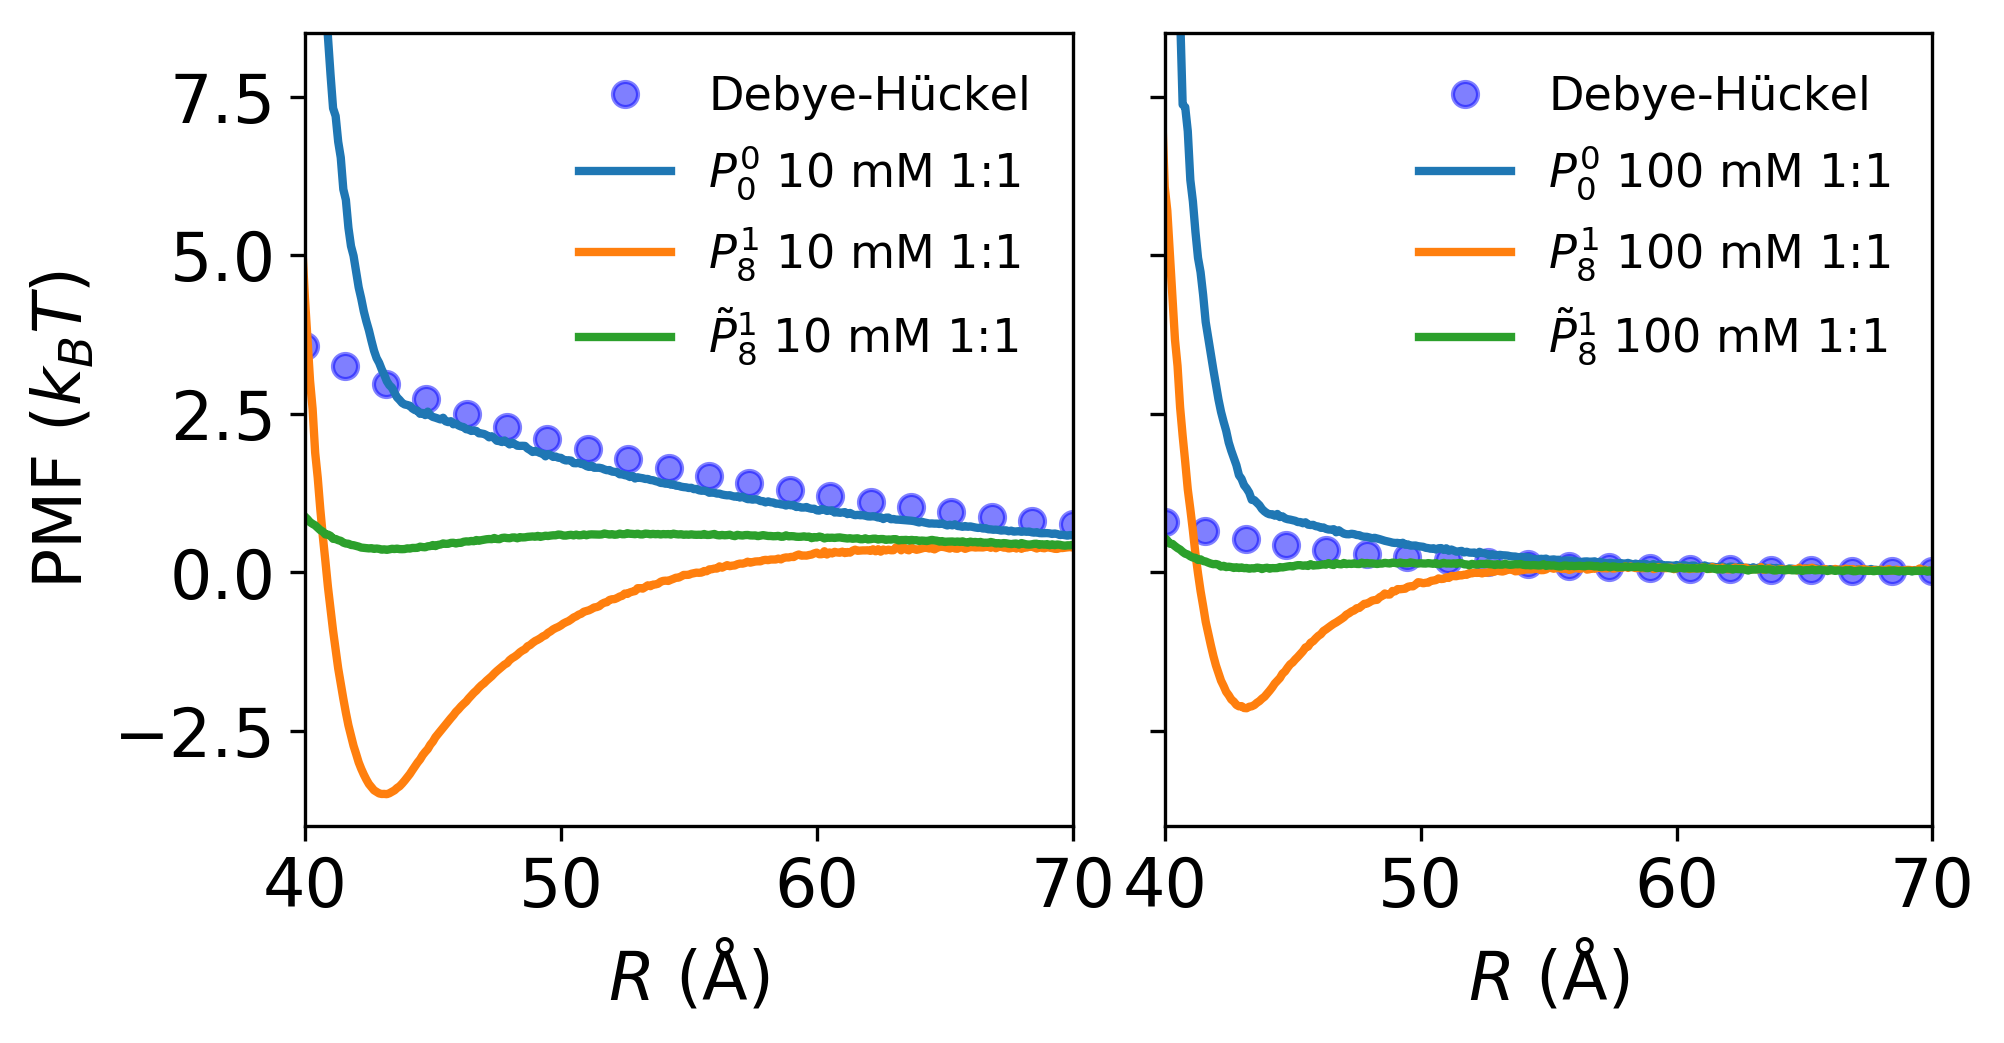

In [11]:
%cd -q $workdir/mc
def plotpmf(data, xlim, ax, shift=0):
    for directory, d in data.items():
        ionstr = ''
        for ion, N in d.ions.items(): # loop over all ion conditions
            ionstr = ion+str(N) + ionstr

        if os.path.isdir(directory):
            %cd -q $directory

            if os.path.isfile('rdf.dat'):
                r, g = np.loadtxt('rdf.dat', unpack=True)
                g = g / g[r>80].mean() # g(r)->1 for large r (our reference state)
                ax.plot(r, -np.log(g)+shift, label=d.label, lw=2)#, color=d.color)

            %cd -q ..

    ax.set_xlabel('$R$ (Å)')
    ax.set_ylabel('PMF ($k_BT$)')
    ax.set_xlim(xlim)
    ax.set_ylim((-4,8.5))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(7)
f.set_figheight(3.5)
f.dpi=300

# Debye-Huckel
from math import sinh
r=np.linspace(40,70,20)
a=22.0 # radius, central+ion (angstrom)

# 10 mM
D=3.04/sqrt(0.01)
QQ = (8*sinh(a/D) / (a/D))**2
ax1.plot( r, 7*QQ/r*np.exp(-r/D), 'bo', alpha=0.5, label=u'Debye-Hückel')

# 100 mM
D=3.04/sqrt(0.1)
QQ = (8*sinh(a/D) / (a/D))**2
ax2.plot( r, 7*QQ/r*np.exp(-r/D), 'bo', alpha=0.5, label=u'Debye-Hückel')

plotpmf(param[['P00-1:1-10mM', 'P18-1:1-10mM', 'P18-1:1-10mM-point']],  ax=ax1, xlim=[40,70], shift=0.28 )
plotpmf(param[['P00-1:1-100mM','P18-1:1-100mM','P18-1:1-100mM-point']], ax=ax2, xlim=[40,70] )

ax1.legend(loc=0, frameon=False, fontsize='x-small', ncol=1)
ax2.legend(loc=0, frameon=False, fontsize='x-small', ncol=1)
ax2.set_ylabel('')
f.subplots_adjust(wspace=0.12)

plt.savefig('pmf-monovalent.png', bbox_inches='tight', dpi=300)

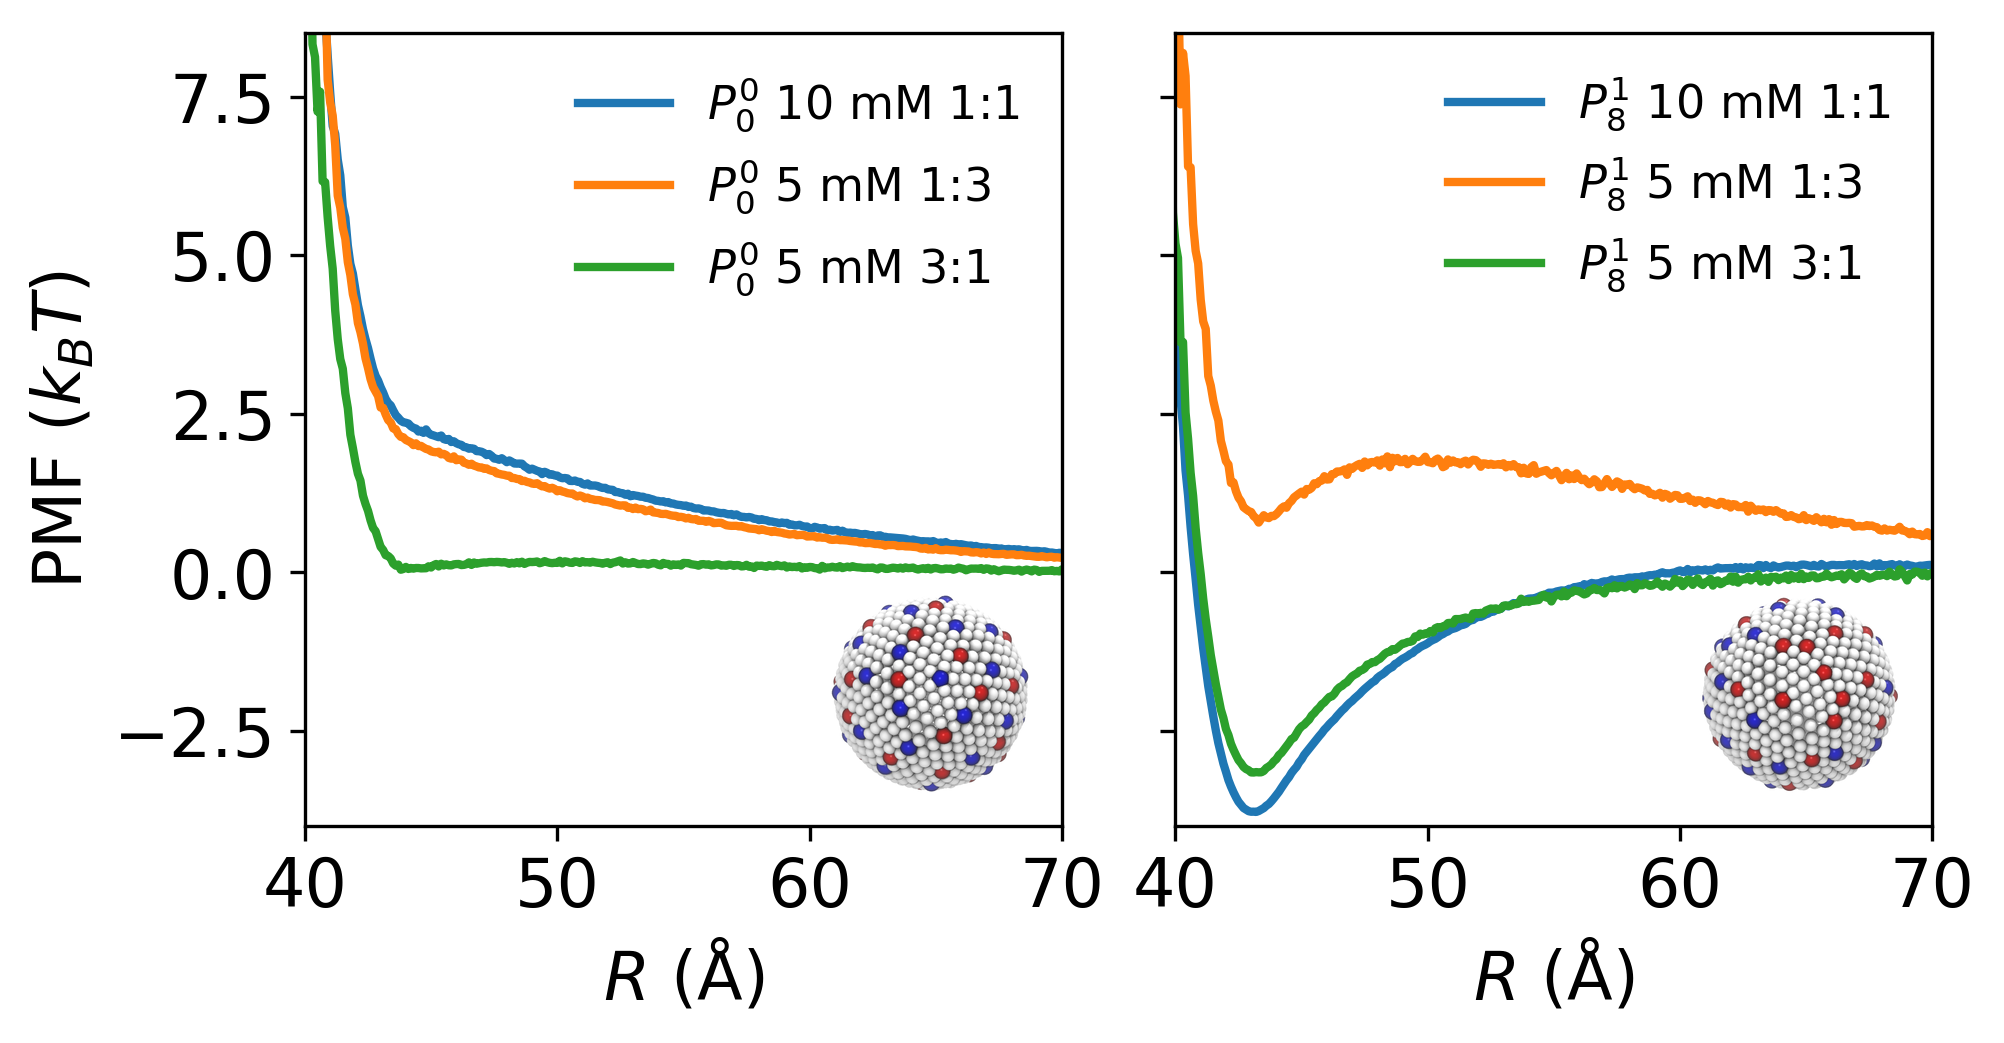

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(7)
f.set_figheight(3.5)
f.dpi=300

plotpmf(param[['P00-1:1-10mM', 'P00-1:3-5mM', 'P00-3:1-5mM']], ax=ax1, xlim=[40,70] )
plotpmf(param[['P18-1:1-10mM', 'P18-1:3-5mM', 'P18-3:1-5mM']], ax=ax2, xlim=[40,70] )

ax1.legend(loc=0, frameon=False, fontsize='x-small')
ax2.legend(loc=0, frameon=False, fontsize='x-small')
ax2.set_ylabel('')

f.subplots_adjust(wspace=0.15)

# image insert
imgsize=200,200
im1 = Image.open('P00.png')
im1.thumbnail(imgsize, Image.ANTIALIAS)
im2 = Image.open('P18.png')
im2.thumbnail(imgsize, Image.ANTIALIAS)
ypos=250
f.figimage(X=np.array(im1).astype(np.float)/255, xo=830, yo=ypos, resize=False, zorder=1)
f.figimage(X=np.array(im2).astype(np.float)/255, xo=1700, yo=ypos, resize=False, zorder=2)

plt.savefig('pmf-trivalent.png', bbox_inches='tight', dpi=300)